In [1]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic
import scipy
from scipy import interpolate

pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]


In [2]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [3]:
def read_timesteps(simname):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(f'/home/akinshol/Data/Timescales/DataFiles/{simname}.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    
    data = pd.DataFrame(data)
    return data

def read_timescales():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_sSFR_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

def read_z0(simname):
    '''Function to read in the data file which contains z=0 information for the various halos'''
    data = []
    with open('/home/akinshol/Data/DataFiles_Archive_20191129/'+ simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data1 = pd.DataFrame(data)
    return data1

In [4]:
def read_new_data():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_sSFR_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

# Gas Density & Temperature Distributions over time

We plot the distribution of gas density and temperature for all gas particles in the halos over time. We do not weight the particles by their masses in this example because I couldn't figure out how to do it properly. 

**Recall the plot below of quenching timescale vs stellar mass.**

We will use this plot as a starting point, and choose our sample of galaxies from those in this plot, which is limited to: galaxies that experience infall and have more than 100 star particles. 

![alt text](../F19/plots/tq_mass_F19_sSFR.png "Title")

The halo IDs that we need are defined in the dictionary below (ruling out the small, early quenching halos)

In [5]:
haloids = {'h148': [2,3,5,6,9,10,11,13,14,21,27,28,32,36,37,45,68,80,163,278,283,329],
           'h229': [20, 22, 23, 27, 55, 73, 113],
           'h242': [10, 12, 24, 30, 41, 80, 439],
           'h329': [11, 33, 137]}

In [8]:
data = read_timesteps('h329')
list(data.keys())

['HIratio',
 'Pram',
 'Prest',
 'Rvir',
 'SNHfrac',
 'a',
 'env_rho',
 'fHI',
 'gas_hi',
 'gas_mass',
 'gas_mass_sphere',
 'gas_r',
 'gas_r_sphere',
 'gas_rho',
 'gas_rho_sphere',
 'gas_temp',
 'gas_temp_sphere',
 'gasfrac',
 'gtemp',
 'h1dist',
 'h1dist_kpc',
 'h1rvir',
 'haloid',
 'inflow_23',
 'inflow_91',
 'inflow_temp_23',
 'inflow_temp_91',
 'mHI',
 'mass',
 'mgas',
 'mstar',
 'outflow_23',
 'outflow_91',
 'outflow_temp_23',
 'outflow_temp_91',
 'ratio',
 'sfr',
 't',
 'time',
 'v_env',
 'v_halo',
 'v_halo1',
 'x',
 'y',
 'z',
 'z0haloid']

In [10]:
data = read_new_data()

In [117]:
haloids = {'h148': [2,3,5,6,9,10,11,13,14,21,27,28,32,36,37,45,68,80,163,278,283,329],
           'h229': [20, 22, 23, 27, 55, 73],
           'h242': [10, 12, 24, 41, 80, 439],
           'h329': [11, 33, 137]}

closest_approach, tquench, tinfall, timescale = np.array([]), np.array([]), np.array([]), np.array([])

for sim in np.unique(data.sim):
    d = data[data.sim == sim]
    t = read_timesteps(sim)
    for haloid in d.haloid:
        if haloid in haloids[sim]:
            timescales = d[d.haloid == haloid]
            timesteps = t[t.z0haloid==haloid]

            h1dist = np.array(timesteps.h1dist,dtype=float)
            closest_approach = np.append(closest_approach, np.min(h1dist))

            tq = timescales.tquench.tolist()[0]
            ti = timescales.tinfall.tolist()[0]
            if not np.isnan(tq) and not np.isnan(ti):
                time = ti - tq
            else:
                time = None

            tquench = np.append(tquench, tq)
            tinfall = np.append(tinfall, ti)
            timescale = np.append(timescale, time)    

In [33]:
len(closest_approach)

39

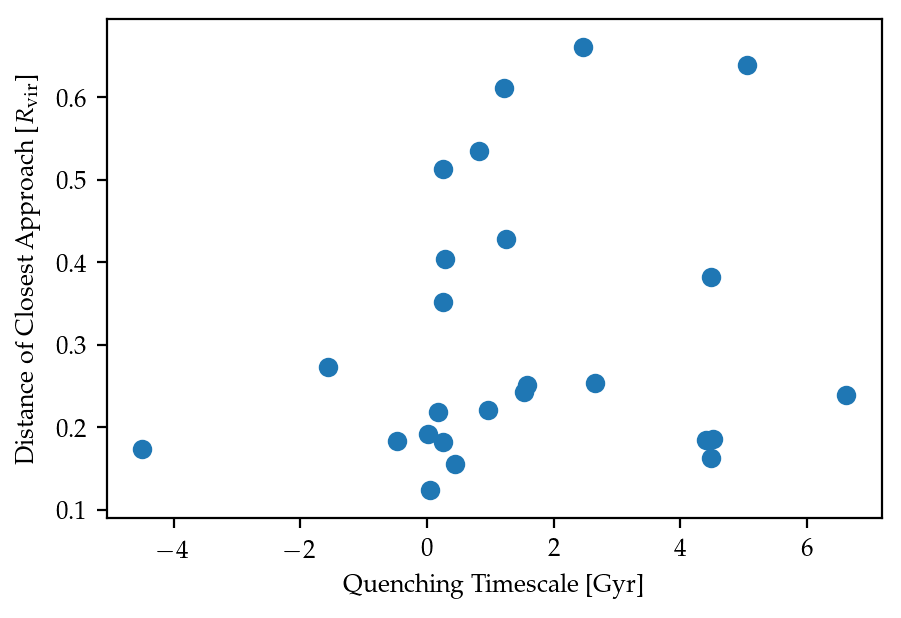

In [36]:
plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(timescale,closest_approach)
plt.ylabel(r'Distance of Closest Approach [$R_{\mathrm{vir}}$]')
plt.xlabel('Quenching Timescale [Gyr]')
plt.show()

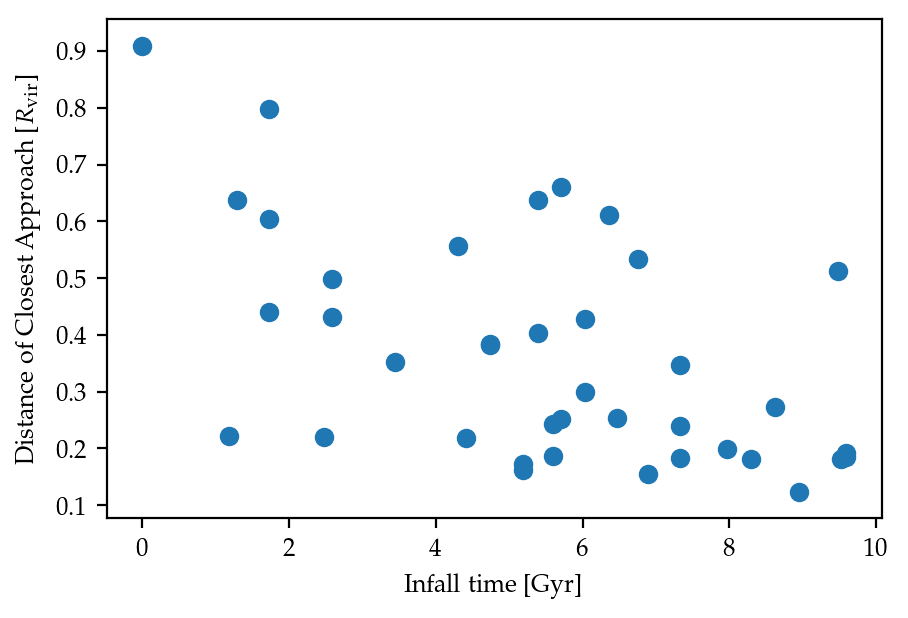

In [40]:
plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(tinfall,closest_approach)
plt.ylabel(r'Distance of Closest Approach [$R_{\mathrm{vir}}$]')
plt.xlabel('Infall time [Gyr]')
plt.show()

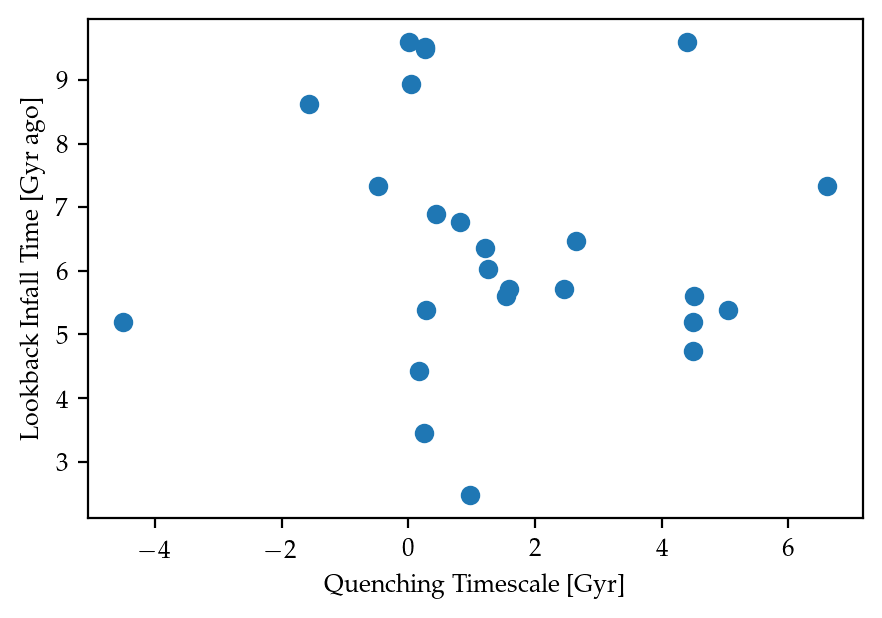

In [41]:
plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(timescale,tinfall)
plt.ylabel(r'Lookback Infall Time [Gyr ago]')
plt.xlabel('Quenching Timescale [Gyr]')
plt.show()

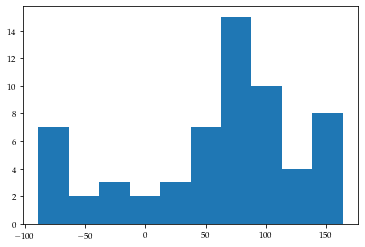

In [46]:
plt.hist(timesteps.y)
plt.show()

In [60]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [213]:
angles, tquenchs, tinfalls, timescale, closest_approach = np.array([]),np.array([]),np.array([]),np.array([]), np.array([])
quenched, mgas, mvir = np.array([],dtype=bool), np.array([]), np.array([])
gas_temps, gas_masses = [], []
etas = np.array([])

age = 13.800797497330507

for sim in ['h148','h229','h242','h329']:
    timesteps1 = read_timesteps(sim)
    timescales1 = read_timescales()
    for haloid in haloids[sim]:
        timesteps = timesteps1[timesteps1.z0haloid == haloid]
        timescales = timescales1[(timescales1.haloid== haloid)&(timescales1.sim==sim)]

        tinfall_lbt = timescales.tinfall.tolist()[0]
        tinfall = age - tinfall_lbt
        tquench_lbt = timescales.tquench.tolist()[0]
        
        if not np.isnan(tquench_lbt) and not np.isnan(tinfall_lbt):
            timesc = tinfall_lbt - tquench_lbt
        elif np.isnan(tquench_lbt) and not np.isnan(tinfall_lbt):
            timesc = tinfall_lbt
        else:
            timesc = None
        
        
        h1dist = np.array(timesteps.h1dist,dtype=float)
        closest_approach = np.append(closest_approach, np.min(h1dist))
        
        q = bool(timescales.quenched.tolist()[0])
        quenched = np.append(quenched, q)
        
        
        

        displacement = []
        for x, y, z in zip(timesteps.x, timesteps.y, timesteps.z):
            displacement.append((x,y,z))

        displacement = np.array(displacement)

        v_rel = []
        for v_halo, v_halo1 in zip(timesteps.v_halo, timesteps.v_halo1):
            v_halo = np.array(v_halo)
            v_halo1 = np.array(v_halo1)
            v_rel.append(v_halo - v_halo1)
        v_rel = np.array(v_rel)

        time = np.array(timesteps.time)
        infall_index = np.argmin(np.abs(time-tinfall+1))

        v_i = v_rel[infall_index]
        d_i = displacement[infall_index]
        
        mg = np.array(timesteps.mgas)
        mg_i = mg[infall_index]
        
        gas_temp = np.array(timesteps.gas_temp_sphere)
        gas_mass = np.array(timesteps.gas_mass_sphere)
        gas_temp_i = gas_temp[infall_index]
        gas_mass_i = gas_mass[infall_index]
        gas_temps.append(gas_temp_i)
        gas_masses.append(gas_mass_i)

        mgas = np.append(mgas, mg_i)
        
        eta = np.array(timesteps.outflow_91) / np.array(timesteps.sfr)
        
        eta_i = np.mean(eta[infall_index:infall_index+5])
        etas = np.append(etas, eta_i)
        
        angles = np.append(angles, angle_between(v_i, -d_i) * 180 / np.pi)
        tquenchs = np.append(tquenchs, tquench_lbt)
        tinfalls = np.append(tinfalls, tinfall_lbt)
        timescale = np.append(timescale, timesc)
        
gas_temps = np.array(gas_temps)
gas_masses = np.array(gas_masses)


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


In [171]:
timesteps.keys()

Index(['HIratio', 'Pram', 'Prest', 'Rvir', 'SNHfrac', 'a', 'env_rho', 'fHI',
       'gas_hi', 'gas_mass', 'gas_mass_sphere', 'gas_r', 'gas_r_sphere',
       'gas_rho', 'gas_rho_sphere', 'gas_temp', 'gas_temp_sphere', 'gasfrac',
       'gtemp', 'h1dist', 'h1dist_kpc', 'h1rvir', 'haloid', 'inflow_23',
       'inflow_91', 'inflow_temp_23', 'inflow_temp_91', 'mHI', 'mass', 'mgas',
       'mstar', 'outflow_23', 'outflow_91', 'outflow_temp_23',
       'outflow_temp_91', 'ratio', 'sfr', 't', 'time', 'v_env', 'v_halo',
       'v_halo1', 'x', 'y', 'z', 'z0haloid'],
      dtype='object')

In [180]:
etas

array([1.88766282e-01, 1.48928861e+00, 6.67108813e-02, 2.64885954e+00,
       9.79622729e-01, 0.00000000e+00, 5.62799122e+01, 5.15870379e+00,
       1.59012271e-01, 2.40080656e+01, 1.36081825e+00, 1.47057113e+01,
       0.00000000e+00,            nan, 1.00703124e+00, 4.22079463e+01,
       7.96786307e+01, 3.75869946e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00,            inf, 0.00000000e+00, 2.14360514e+01,
       0.00000000e+00, 0.00000000e+00, 8.69428695e+00,            nan,
       1.48471095e+00, 3.49470858e+00, 0.00000000e+00, 5.77109822e-01,
       2.20909809e+01,            inf, 2.10225888e+01, 3.11414000e-01,
       4.85886802e+01])

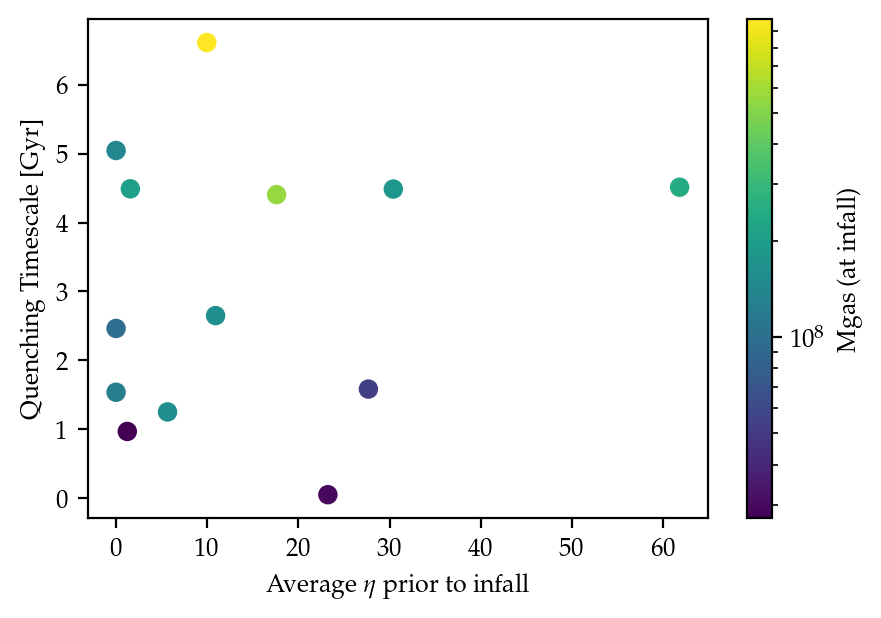

In [201]:
plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(etas[quenched],timescale[quenched],c=mgas[quenched],norm=mpl.colors.LogNorm())
#plt.scatter(etas[~quenched], timescale[~quenched], edgecolor='r')
plt.xlabel(r'Average $\eta$ prior to infall')

plt.ylabel('Quenching Timescale [Gyr]')
plt.colorbar(label='Mgas (at infall)')
plt.show()

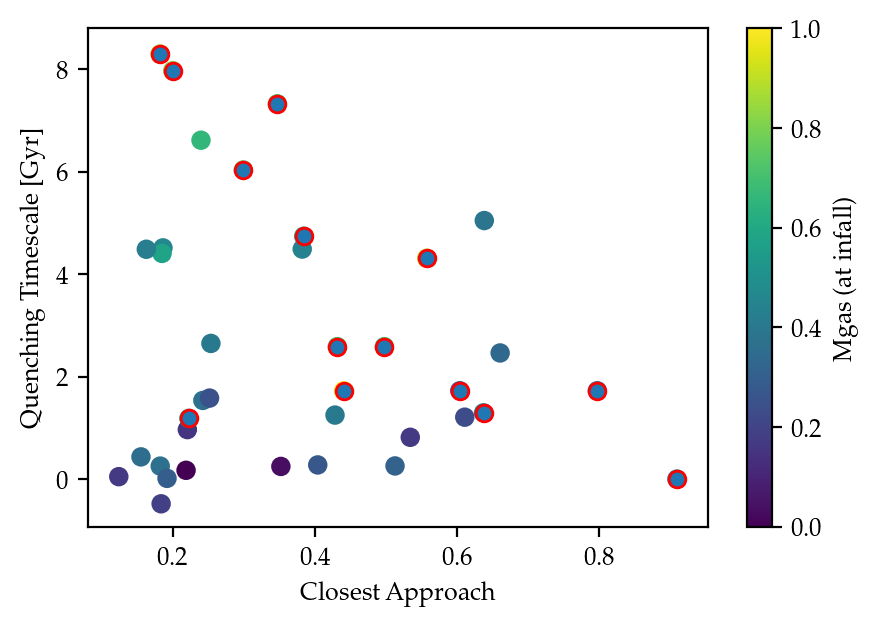

In [125]:
plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(closest_approach,timescale,c=mgas,norm=mpl.colors.LogNorm())
plt.scatter(closest_approach[~quenched], timescale[~quenched], edgecolor='r')
plt.xlabel(r'Closest Approach')
plt.ylabel('Quenching Timescale [Gyr]')
plt.colorbar(label='Mgas (at infall)')
plt.show()

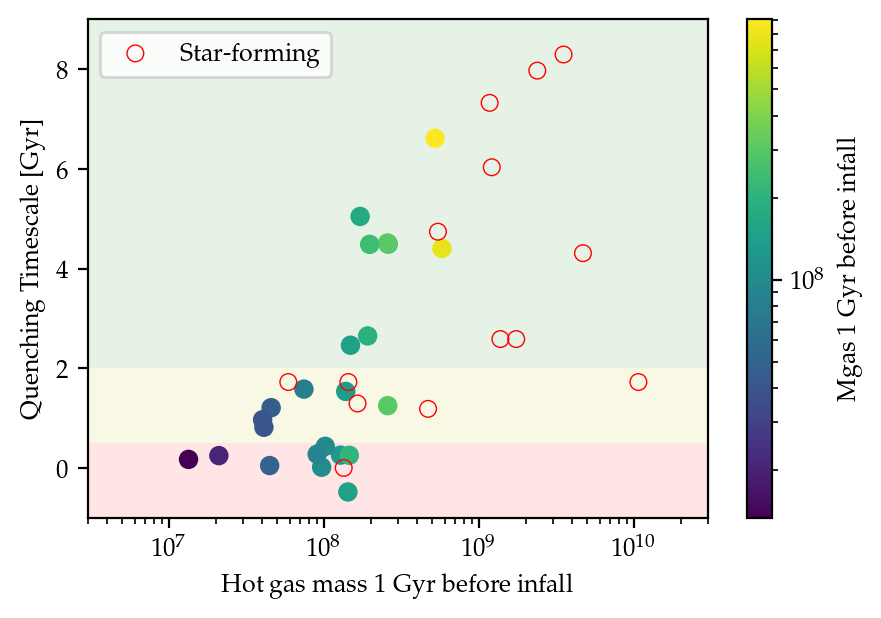

In [228]:
cold_gas = np.array([sum(gas_mass[gas_temp < 1e3]) for gas_mass, gas_temp in zip(gas_masses, gas_temps)])
hot_gas = np.array([sum(gas_mass[gas_temp > 1e3]) for gas_mass, gas_temp in zip(gas_masses, gas_temps)])


plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(hot_gas[quenched],timescale[quenched],c=mgas[quenched], norm=mpl.colors.LogNorm())
plt.colorbar(label='Mgas 1 Gyr before infall')
plt.scatter(hot_gas[~quenched], timescale[~quenched], edgecolor='r', linewidths=0.5, facecolor='none', label='Star-forming')
plt.semilogx()
plt.xlim(3e6, 3e10)
plt.ylim(-1,9)
plt.fill_between([1e2, 1e14], [-1,-1], [0.5, 0.5], edgecolor='none', facecolor='r', alpha=0.1, zorder=0)
plt.fill_between([1e2, 1e14], [0.5,0.5], [2,2], edgecolor='none', facecolor='y', alpha=0.1, zorder=0)
plt.fill_between([1e2, 1e14], [2,2], [9,9], edgecolor='none', facecolor='g', alpha=0.1, zorder=0)
plt.xlabel(r'Hot gas mass 1 Gyr before infall')
plt.ylabel('Quenching Timescale [Gyr]')
plt.legend()
plt.show()

No handles with labels found to put in legend.


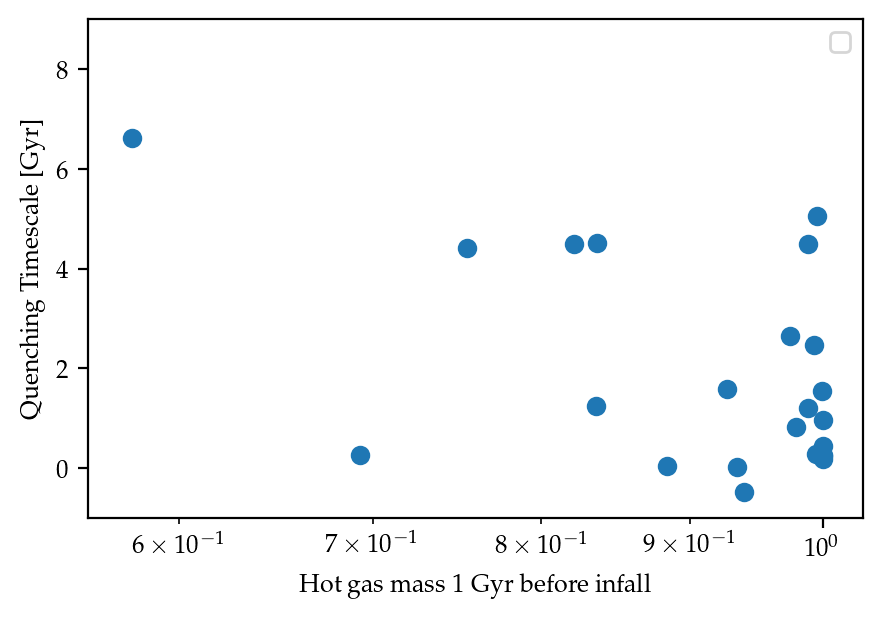

In [229]:
cold_gas = np.array([sum(gas_mass[gas_temp < 1e3]) for gas_mass, gas_temp in zip(gas_masses, gas_temps)])
hot_gas = np.array([sum(gas_mass[gas_temp > 1e3]) for gas_mass, gas_temp in zip(gas_masses, gas_temps)])


plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(hot_gas[quenched]/mgas[quenched],timescale[quenched])
plt.semilogx()
# plt.xlim(3e6, 3e10)
plt.ylim(-1,9)
# plt.fill_between([1e2, 1e14], [-1,-1], [0.5, 0.5], edgecolor='none', facecolor='r', alpha=0.1, zorder=0)
# plt.fill_between([1e2, 1e14], [0.5,0.5], [2,2], edgecolor='none', facecolor='y', alpha=0.1, zorder=0)
# plt.fill_between([1e2, 1e14], [2,2], [9,9], edgecolor='none', facecolor='g', alpha=0.1, zorder=0)
plt.xlabel(r'Hot gas mass 1 Gyr before infall')
plt.ylabel('Quenching Timescale [Gyr]')
plt.legend()
plt.show()

In [218]:
hot_gas

array([1.06943531e+10, 4.69217865e+09, 1.37623166e+09, 1.74063170e+09,
       5.44198693e+08, 1.34223109e+08, 1.21069155e+09, 2.58087668e+08,
       1.64760746e+08, 1.43846950e+08, 1.17297552e+09, 5.21637317e+08,
       5.89327288e+07, 2.10049370e+07, 2.60100841e+08, 1.91601168e+08,
       2.57614431e+08, 1.42840230e+08, 1.28012972e+08, 1.02042894e+08,
       1.38287622e+08, 1.45848684e+08, 1.71264437e+08, 5.77716472e+08,
       4.56569742e+07, 4.10169869e+07, 7.42888756e+07, 1.33855049e+07,
       3.51759913e+09, 2.38090057e+09, 1.48416986e+08, 4.02398523e+07,
       1.97348855e+08, 9.67077113e+07, 4.70081206e+08, 9.04697529e+07,
       4.46795723e+07])

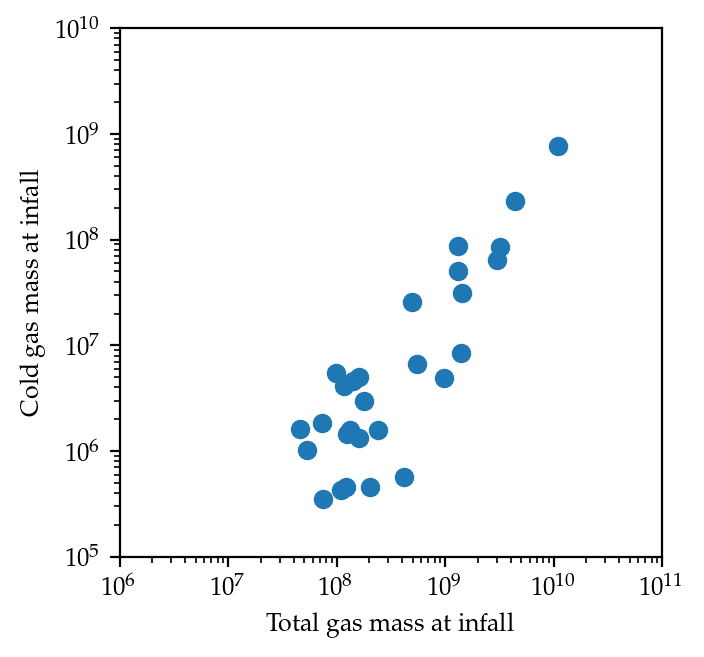

In [152]:
plt.figure(figsize=(3.5,3.5),dpi=200)
plt.scatter(mgas,cold_gas)
plt.loglog()
plt.ylim(1e5, 1e10)
plt.xlim(1e6,1e11)
plt.ylabel(r'Cold gas mass at infall')
plt.xlabel('Total gas mass at infall')
plt.show()

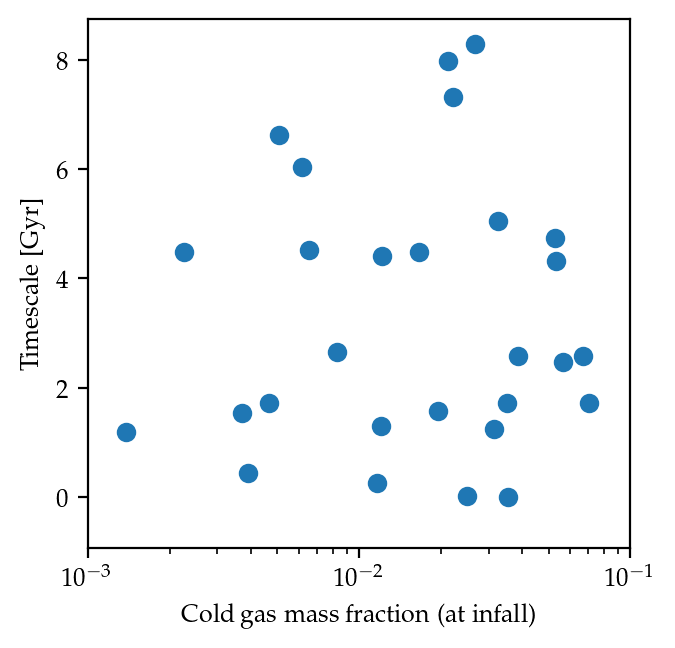

In [157]:
plt.figure(figsize=(3.5,3.5),dpi=200)
plt.scatter(cold_gas,timescale)
plt.semilogx()
plt.xlim(1e-3,1e-1)
plt.ylabel(r'Timescale [Gyr]')
plt.xlabel('Cold gas mass fraction (at infall)')
plt.show()

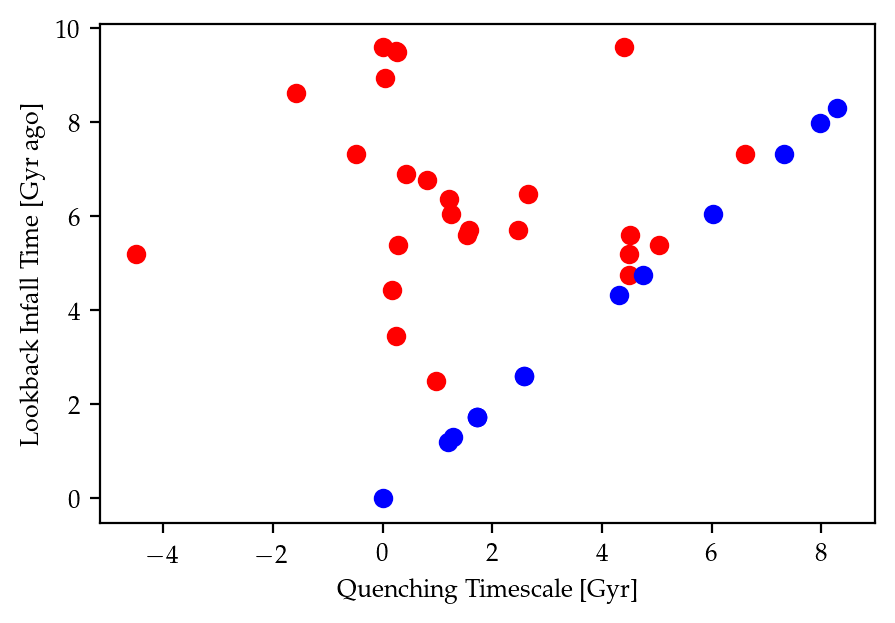

In [105]:
plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(timescale[quenched],tinfalls[quenched], c='r')
plt.scatter(timescale[~quenched], tinfalls[~quenched], c='b')
plt.ylabel(r'Lookback Infall Time [Gyr ago]')
plt.xlabel('Quenching Timescale [Gyr]')
plt.show()

In [66]:
for d, v in zip(displacement, v_rel):
    print(angle_between(d, v))

0.8706745705463353
0.8263408834378644
0.771751272866536
0.7298280284588288
0.7000127349550225
0.6798704721440142
0.6680320386145059
0.6526090454285401
0.631864652289969
0.6164316379165781
0.6110219281958923
0.8922645419833
0.8991618752491886
0.849805626542921
0.8337535394652725
0.7563469126156628
0.7082174249103239
0.7575917836732394
1.6190240466056642
1.9124123931930772
2.494078733845245
2.675898144632921
2.3114509780291668
2.6260168573792266
2.549989389346423
2.6225874457136764
2.7327603522115713
2.496352203035773
2.5374816396966944
2.6058965634267803
2.622772062597244
2.656874367339762
2.5737040164368934
2.5148287274284753
2.4543136567259274
2.456242705777195
2.3949852714272124
2.392641922683496
2.598166788193569
2.6871063290718125
2.73429069723689
2.7530299472921222
2.7470299157240947
2.6859357057738706
2.879624451910332
2.9035498623379783
2.7204152745988526
2.3317396633958514
2.500816889798626
2.9439197349028596
3.0407403295003452
2.4708836030610977
2.4234253248704087
2.6622460639

In [89]:
data = read_timescales()
data[data.sim=='h148']

,M_star,haloid,n_star,quenched,sim,tinfall,tinfall_lower,tinfall_upper,tquench,tquench_lower,tquench_upper
0,2.268773e+09,2,435389,False,h148,1.723922e+00,2.154902,1.723922e+00,NaN,NaN,NaN
1,1.505383e+09,3,295443,False,h148,4.309804e+00,4.740784,4.309804e+00,NaN,NaN,NaN
2,4.317847e+08,5,85749,False,h148,2.585882e+00,3.033698,2.154902e+00,NaN,NaN,NaN
3,3.315968e+08,6,65528,False,h148,2.585882e+00,3.033698,2.585882e+00,NaN,NaN,NaN
4,2.359537e+08,9,47542,False,h148,4.740784e+00,4.740784,4.309804e+00,NaN,NaN,NaN
5,2.452897e+07,10,4919,False,h148,2.450751e-10,0.430980,NaN,NaN,NaN,NaN
6,1.353323e+08,11,26093,False,h148,6.033725e+00,6.033725,5.602745e+00,NaN,NaN,NaN
7,1.043767e+08,13,21027,True,h148,6.033725e+00,6.033725,5.602745e+00,4.784019,NaN,0.095896
8,1.241519e+07,14,2459,False,h148,1.292941e+00,1.649847,8.619608e-01,NaN,NaN,NaN
9,4.102691e+06,21,815,False,h148,1.723922e+00,1.723922,1.292941e+00,NaN,NaN,NaN


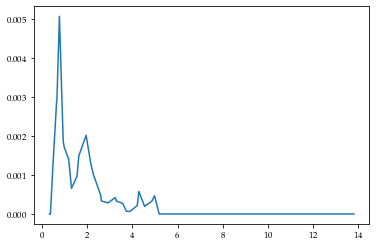

In [191]:
plt.plot(timesteps.time, timesteps.sfr)
plt.show()

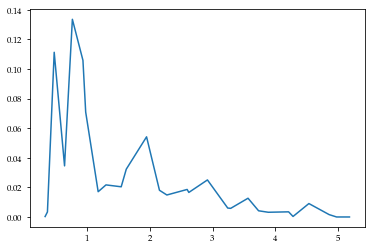

In [193]:
plt.plot(timesteps.time, timesteps.outflow_91)
plt.show()

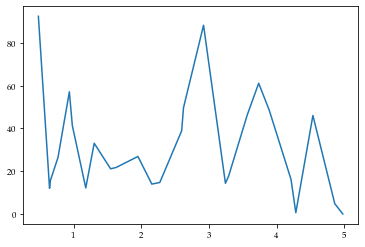

In [194]:
plt.plot(timesteps.time, timesteps.outflow_91 / timesteps.sfr)
plt.show()

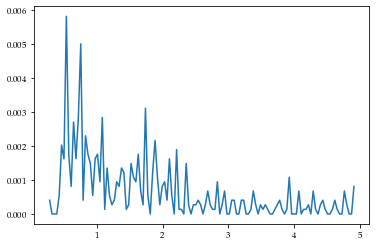

In [197]:
d = read_z0('h329')
d = d[d.haloid==137]
sfh, binEdges = d.sfh.tolist()[0], d.sfhbins.tolist()[0]
bincenters = 0.5*(binEdges[1:] + binEdges[:-1])
plt.plot(bincenters,sfh)
plt.show()

In [8]:
timescales = read_timescales()

Starting halo h148-2
Starting halo h148-3
Starting halo h148-5
Starting halo h148-6
Starting halo h148-9
Starting halo h148-10
Starting halo h148-11
Starting halo h148-13
Starting halo h148-14
Starting halo h148-21
Starting halo h148-27
Starting halo h148-28
Starting halo h148-32
Starting halo h148-36
Starting halo h148-37
Starting halo h148-45
Starting halo h148-68
Starting halo h148-80
Starting halo h148-163
Starting halo h148-278
Starting halo h148-283
Starting halo h148-329
Starting halo h229-20
Starting halo h229-22
Starting halo h229-23
Starting halo h229-27
Starting halo h229-55
Starting halo h229-73
Starting halo h229-113
Starting halo h242-10
Starting halo h242-12
Starting halo h242-24
Starting halo h242-30
Starting halo h242-41
Starting halo h242-80
Starting halo h242-439
Starting halo h329-11
Starting halo h329-33
Starting halo h329-137


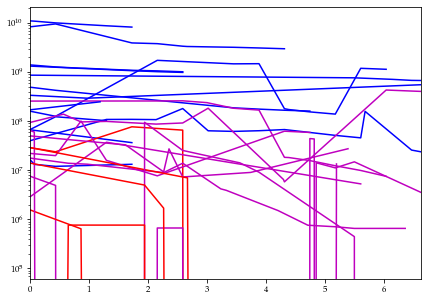

In [14]:
age = 13.800797497330507

haloids = {'h148': [2,3,5,6,9,10,11,13,14,21,27,28,32,36,37,45,68,80,163,278,283,329],
           'h229': [20, 22, 23, 27, 55, 73, 113],
           'h242': [10, 12, 24, 30, 41, 80, 439],
           'h329': [11, 33, 137]}


plt.figure(figsize=(7,5))

for sim in ['h148','h229','h242','h329']:
    for haloid in haloids[sim]:
        print(f'Starting halo {sim}-{haloid}')
        d = read_timesteps(sim)
        d = d[d.haloid==haloid]

        timescales_current = timescales[(timescales.haloid==haloid)&(timescales.sim==sim)]
        tinfall = timescales_current.tinfall.tolist()[0]
        tquench = timescales_current.tquench.tolist()[0]
        tau = tinfall-tquench
        q = bool(timescales_current.quenched.tolist()[0])

        if tau < 1:
            c = 'r'
        elif (tau>1) and q:
            c = 'm'
        elif not q:
            c = 'b'

        time = np.array(d.time - (age-tinfall))

        plt.plot(time, d.mgas, c=c)


plt.semilogy()
plt.xlim(0,6.62)
plt.show()


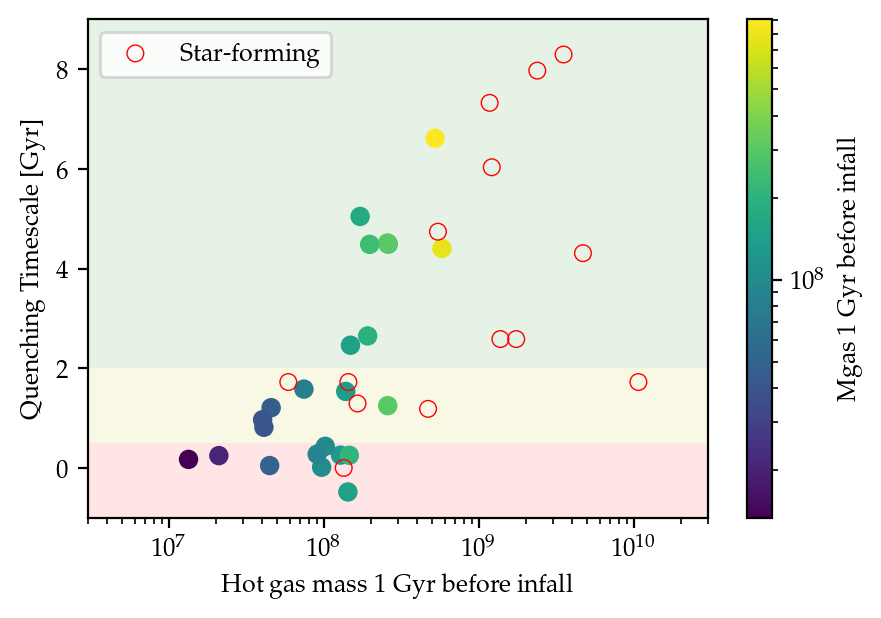

In [228]:
cold_gas = np.array([sum(gas_mass[gas_temp < 1e3]) for gas_mass, gas_temp in zip(gas_masses, gas_temps)])
hot_gas = np.array([sum(gas_mass[gas_temp > 1e3]) for gas_mass, gas_temp in zip(gas_masses, gas_temps)])


plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(hot_gas[quenched],timescale[quenched],c=mgas[quenched], norm=mpl.colors.LogNorm())
plt.colorbar(label='Mgas 1 Gyr before infall')
plt.scatter(hot_gas[~quenched], timescale[~quenched], edgecolor='r', linewidths=0.5, facecolor='none', label='Star-forming')
plt.semilogx()
plt.xlim(3e6, 3e10)
plt.ylim(-1,9)
plt.fill_between([1e2, 1e14], [-1,-1], [0.5, 0.5], edgecolor='none', facecolor='r', alpha=0.1, zorder=0)
plt.fill_between([1e2, 1e14], [0.5,0.5], [2,2], edgecolor='none', facecolor='y', alpha=0.1, zorder=0)
plt.fill_between([1e2, 1e14], [2,2], [9,9], edgecolor='none', facecolor='g', alpha=0.1, zorder=0)
plt.xlabel(r'Hot gas mass 1 Gyr before infall')
plt.ylabel('Quenching Timescale [Gyr]')
plt.legend()
plt.show()

In [25]:
# fraction of hot gas at infall
data = read_new_data()

haloids = {'h148': [2,3,5,6,9,10,11,13,14,21,27,28,32,36,37,45,68,80,163,278,283,329],
           'h229': [20, 22, 23, 27, 55, 73],
           'h242': [10, 12, 24, 41, 80, 439],
           'h329': [11, 33, 137]}

mgas, mgas_hot, tquench, tinfall, timescale, quenched = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([],dtype=bool)

for sim in np.unique(data.sim):
    d = data[data.sim == sim]
    t = read_timesteps(sim)
    for haloid in d.haloid:
        if haloid in haloids[sim]:
            timescales = d[d.haloid == haloid]
            timesteps = t[t.z0haloid==haloid]

            tq = timescales.tquench.tolist()[0]
            ti = timescales.tinfall.tolist()[0]
            time_arr = np.array(timesteps.time)
            
            if not np.isnan(tq) and not np.isnan(ti):
                time = ti - tq
            else:
                time = None
        
            q = bool(timescales.quenched.tolist()[0])
            tquench = np.append(tquench, tq)
            tinfall = np.append(tinfall, ti)
            timescale = np.append(timescale, time)  
            quenched = np.append(quenched, q)

            gas_mass = timesteps.gas_mass.tolist()[np.argmin(np.abs(time_arr-ti))]
            gas_temp = timesteps.gas_temp.tolist()[np.argmin(np.abs(time_arr-ti))]
            
            mg = np.sum(gas_mass)
            mg_hot = np.sum(gas_mass[gas_temp > 1e4])
            
            mgas = np.append(mgas,mg)
            mgas_hot = np.append(mgas_hot,mg_hot)


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


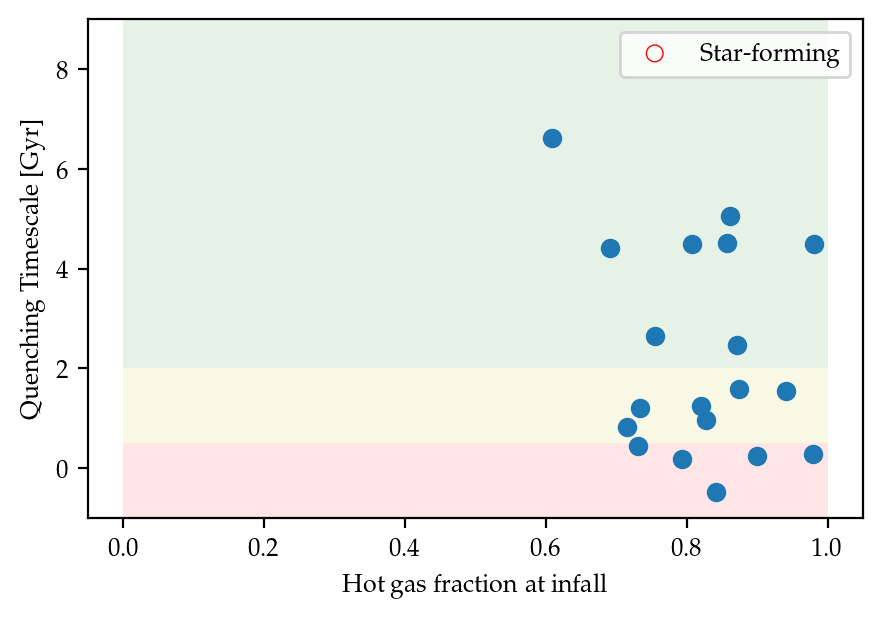

In [30]:
frac_hot = mgas_hot / mgas

plt.figure(figsize=(5,3.3),dpi=200)
plt.scatter(frac_hot[quenched],timescale[quenched])
plt.scatter(frac_hot[~quenched], timescale[~quenched], edgecolor='r', linewidths=0.5, facecolor='none', label='Star-forming')

plt.ylim(-1,9)

plt.fill_between([0, 1], [-1,-1], [0.5, 0.5], edgecolor='none', facecolor='r', alpha=0.1, zorder=0)
plt.fill_between([0, 1], [0.5,0.5], [2,2], edgecolor='none', facecolor='y', alpha=0.1, zorder=0)
plt.fill_between([0, 1], [2,2], [9,9], edgecolor='none', facecolor='g', alpha=0.1, zorder=0)
plt.xlabel(r'Hot gas fraction at infall')
plt.ylabel('Quenching Timescale [Gyr]')
plt.legend()
plt.show()